In [2]:
# general imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from scipy import stats

# nlp imports
import nltk
import nltk.data
from nltk.corpus import stopwords
import string
from gensim.models.word2vec import Word2Vec
from imblearn.combine import SMOTETomek


# model imports
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer

# visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(4)

In [7]:
data=pd.read_csv("C:/Users/82104/Desktop/객체 팀플/dataset/mbti_1.csv")

In [8]:
train, test = train_test_split(data)    

train_df = train.copy()
train.head()

,type,posts
5912,INFP,"'-Early morning sunrise in the Winter, especia..."
2414,INTJ,"'Social 1) Generally, I positively associate w..."
4933,INFP,'I've been quiet but I'm still lurking so I ca...
8188,ISFP,'It's not something I'd personally look forwar...
2426,ENFJ,'http://youtu.be/Cisk_9uTW0o|||IIN that I have...


In [9]:
test.head()

,type,posts
8623,INFP,'So do you INFP peeps get jealous often? And b...
8009,ENTP,'This is basically a new project that some fri...
1838,INFJ,'So true! ;)|||It's not just you...|||It doesn...
7967,ENTP,'I love your writing style|||I dont have a cup...
827,ENFP,"'Nebosite and creative, you both nailed the re..."


In [10]:
dist = train['type'].value_counts()

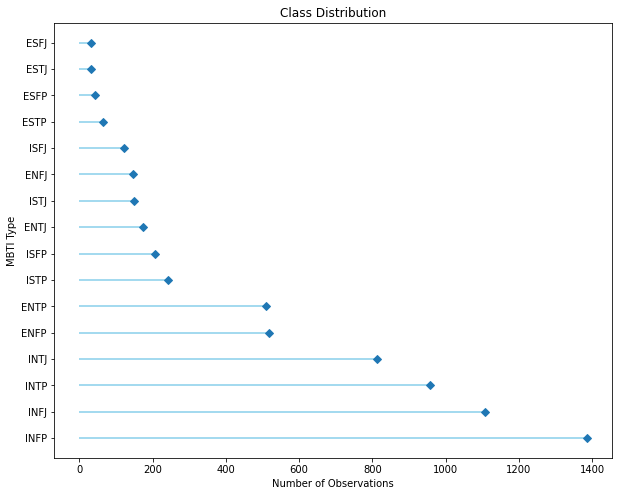

In [11]:
plt.figure(figsize=(10,8),edgecolor='b')
plt.hlines(y=list(range(16)), xmin=0, xmax=dist, color='skyblue')
plt.plot(dist, list(range(16)), "D")
plt.yticks(list(range(16)), dist.index)
plt.xlabel('Number of Observations')
plt.ylabel('MBTI Type')
plt.title('Class Distribution')
plt.show()

In [12]:
def encode_type(df):
    # 'type'열을 4 개의 이진 열로 변환하는 기능,
    # 즉, introvert는 0이되고 extrovert는 1이됩니다.
    # 데이터 프레임을 반환합니다.

    # 목록에서 '유형'열 가져 오기
    listy = list(df['type'])

   
    # 네 글자를 네 가지 카테고리로 분리
    mind = [x[0] for x in listy]
    energy = [x[1] for x in listy]
    nature =  [x[2] for x in listy]
    tactics = [x[3] for x in listy]

    
    # 새 열 만들기
    df['mind'] = mind
    df['energy'] = energy
    df['nature'] = nature
    df['tactics'] = tactics

    # 카테고리에 정수 값 할당
    df['mind'] = df['mind'].apply(lambda x: 1 if x == 'E' else 0)    
    df['energy'] = df['energy'].apply(lambda x: 1 if x == 'N' else 0)
    df['nature'] = df['nature'].apply(lambda x: 1 if x == 'T' else 0)
    df['tactics'] = df['tactics'].apply(lambda x: 1 if x == 'J' else 0)

    return df.drop('type', axis=1)

In [13]:
train = encode_type(train)

C:\Users\82104\anaconda3\envs\tf2.3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\82104\anaconda3\envs\tf2.3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\82104\anaconda3\envs\tf2.3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [14]:
train.head()

,posts,mind,energy,nature,tactics
5912,"'-Early morning sunrise in the Winter, especia...",0,1,0,0
2414,"'Social 1) Generally, I positively associate w...",0,1,1,1
4933,'I've been quiet but I'm still lurking so I ca...,0,1,0,0
8188,'It's not something I'd personally look forwar...,0,0,0,0
2426,'http://youtu.be/Cisk_9uTW0o|||IIN that I have...,1,1,0,1


In [15]:
def post_to_wordlist(post, remove_stopwords=False):
    # 문서를 일련의 단어로 변환하는 기능,
    # 선택적으로 불용어 제거. 단어 목록 반환

    post_text = post
    
    # 1. 비 문자 제거
    post_text = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 2. 단어를 소문자로 변환하고 분할
    words = post_text.lower().split()
    
    # 3. 선택적으로 불용어 제거 (기본값은 false)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if w not in stops]
    
    return(words)

In [16]:
#NLTK는 영어 코퍼스를 토큰화하기 위한 도구들을 제공

nltk.download('punkt')   
# punkt tokenizer 로드
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def post_to_sentences(post, tokenizer=tokenizer, remove_stopwords=False):
    # 게시물을 구문 분석된 문장으로 분할하는 기능. a를 반환.
    # 문장 목록, 여기서 각 문장은 단어 목록
    
    # 1. NLTK Tokenizer를 사용하여 문단을 문장으로 나눔
    raw_sentences = tokenizer.tokenize(post)
    
    # 2. 각 문장을 반복
    sentences = []
    for raw_sentence in raw_sentences:
        # 문장이 비어 있으면 건너뜀
        if len(raw_sentence) > 0:
           # 그렇지 않으면 review_to_wordlist를 불러와 단어 목록 확인
            sentences.append(post_to_wordlist(raw_sentence, remove_stopwords))
    # 문장 목록 반환(각 문장은 단어 목록)
    return sentences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\82104\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [17]:
sentences = []  # 문장 목록 초기화

#train,test set 문장 구문 분석
for post in train['posts']:
    sentences += post_to_sentences(post.strip(), tokenizer)

for post in test['posts']:
    sentences += post_to_sentences(post, tokenizer)

In [18]:
# 개수 확인
len(sentences)

600061

In [19]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 1000   # 워드 벡터 차원.
min_word_count = 10   # 최소 단어 개수
num_workers = 4       # 병렬 실행할 스레드 수
context = 10          # 윈도우 사이즈
downsampling = 1e-3   # 빈번한 단어에 대한 샘플링 설정 줄임

# 모델 초기화 및 훈련
print("Training model...")
w2v_model = Word2Vec(sentences, workers=num_workers,
                     size=num_features, min_count=min_word_count,
                     window=context, sample=downsampling)

# init_sims 호출 -> 모델의 메모리 효율성 훨씬 높아짐.
w2v_model.init_sims(replace=True)

2020-12-07 13:05:59,979 : INFO : collecting all words and their counts
2020-12-07 13:05:59,982 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-07 13:06:00,108 : INFO : PROGRESS: at sentence #10000, processed 195927 words, keeping 13998 word types


Training model...


2020-12-07 13:06:00,199 : INFO : PROGRESS: at sentence #20000, processed 395219 words, keeping 20149 word types
2020-12-07 13:06:00,298 : INFO : PROGRESS: at sentence #30000, processed 581866 words, keeping 24624 word types
2020-12-07 13:06:00,378 : INFO : PROGRESS: at sentence #40000, processed 779643 words, keeping 29031 word types
2020-12-07 13:06:00,464 : INFO : PROGRESS: at sentence #50000, processed 978496 words, keeping 32992 word types
2020-12-07 13:06:00,548 : INFO : PROGRESS: at sentence #60000, processed 1169309 words, keeping 36399 word types
2020-12-07 13:06:00,638 : INFO : PROGRESS: at sentence #70000, processed 1365628 words, keeping 39643 word types
2020-12-07 13:06:00,723 : INFO : PROGRESS: at sentence #80000, processed 1554414 words, keeping 42428 word types
2020-12-07 13:06:00,814 : INFO : PROGRESS: at sentence #90000, processed 1745121 words, keeping 45198 word types
2020-12-07 13:06:00,899 : INFO : PROGRESS: at sentence #100000, processed 1938801 words, keeping 479

2020-12-07 13:06:21,190 : INFO : EPOCH 1 - PROGRESS: at 11.33% examples, 187705 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:06:22,209 : INFO : EPOCH 1 - PROGRESS: at 13.93% examples, 191690 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:06:23,309 : INFO : EPOCH 1 - PROGRESS: at 16.49% examples, 191337 words/s, in_qsize 8, out_qsize 0
2020-12-07 13:06:24,338 : INFO : EPOCH 1 - PROGRESS: at 18.65% examples, 189243 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:06:25,403 : INFO : EPOCH 1 - PROGRESS: at 21.07% examples, 189211 words/s, in_qsize 8, out_qsize 0
2020-12-07 13:06:26,430 : INFO : EPOCH 1 - PROGRESS: at 23.65% examples, 191278 words/s, in_qsize 8, out_qsize 0
2020-12-07 13:06:27,479 : INFO : EPOCH 1 - PROGRESS: at 25.81% examples, 189400 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:06:28,479 : INFO : EPOCH 1 - PROGRESS: at 28.48% examples, 192090 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:06:29,514 : INFO : EPOCH 1 - PROGRESS: at 30.53% examples, 190214 words/s, in_qsiz

2020-12-07 13:07:32,702 : INFO : EPOCH 2 - PROGRESS: at 78.90% examples, 199929 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:07:33,709 : INFO : EPOCH 2 - PROGRESS: at 81.56% examples, 200787 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:07:34,740 : INFO : EPOCH 2 - PROGRESS: at 84.21% examples, 201215 words/s, in_qsize 8, out_qsize 0
2020-12-07 13:07:35,760 : INFO : EPOCH 2 - PROGRESS: at 87.00% examples, 201903 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:07:36,798 : INFO : EPOCH 2 - PROGRESS: at 89.85% examples, 202640 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:07:37,828 : INFO : EPOCH 2 - PROGRESS: at 92.67% examples, 203388 words/s, in_qsize 8, out_qsize 0
2020-12-07 13:07:38,852 : INFO : EPOCH 2 - PROGRESS: at 95.67% examples, 204297 words/s, in_qsize 8, out_qsize 0
2020-12-07 13:07:39,873 : INFO : EPOCH 2 - PROGRESS: at 98.36% examples, 204792 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:07:40,330 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-

2020-12-07 13:08:39,533 : INFO : EPOCH 4 - PROGRESS: at 58.03% examples, 214955 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:08:40,557 : INFO : EPOCH 4 - PROGRESS: at 60.70% examples, 215403 words/s, in_qsize 8, out_qsize 0
2020-12-07 13:08:41,558 : INFO : EPOCH 4 - PROGRESS: at 63.49% examples, 216272 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:08:42,589 : INFO : EPOCH 4 - PROGRESS: at 66.27% examples, 216517 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:08:43,609 : INFO : EPOCH 4 - PROGRESS: at 69.24% examples, 217448 words/s, in_qsize 8, out_qsize 0
2020-12-07 13:08:44,624 : INFO : EPOCH 4 - PROGRESS: at 71.96% examples, 217781 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:08:45,633 : INFO : EPOCH 4 - PROGRESS: at 74.71% examples, 218139 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:08:46,650 : INFO : EPOCH 4 - PROGRESS: at 77.54% examples, 218629 words/s, in_qsize 7, out_qsize 0
2020-12-07 13:08:47,684 : INFO : EPOCH 4 - PROGRESS: at 80.32% examples, 219009 words/s, in_qsiz

In [20]:
w2v_model.most_similar('sad')

C:\Users\82104\anaconda3\envs\tf2.3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('lonely', 0.6503924131393433),
 ('angry', 0.6068885326385498),
 ('depressed', 0.5973078012466431),
 ('nostalgic', 0.5879408121109009),
 ('depressing', 0.5599201917648315),
 ('happy', 0.5574836730957031),
 ('hopeful', 0.5564652681350708),
 ('cry', 0.5329968929290771),
 ('anxious', 0.5287733674049377),
 ('embarrassed', 0.525233268737793)]

In [21]:
def makeFeatureVec(words, model, num_features):
    # 주어진 단어의 벡터를 모두 평균화하는 함수
    
    # 빈 Numpy 배열을 미리 초기화속도용).
    featureVec = np.zeros((num_features,), dtype="float32")
    
    nwords = 0.
    
    # Index2word-> 단어 이름 포함 목록
    # 모델의 단어. 속도를 위해 세트 변환
    index2word_set = set(model.wv.vocab.keys())
    
    # post의 각 단어 반복, 모델의 단어 있는 경우 반복
    # vocaublary, 피쳐 벡터를 합계에 추가.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
    
    # 결과를 단어 수로 나누어 평균을 구함
    featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(posts, model, num_features):
    # 게시물 세트(각각 단어 목록) 지정하여 계산
    # 각 피쳐 벡터의 평균값 계산 -> 2D Numpy 배열 반환
    
    # 카운터 초기화합
    counter = 0.
    
    #  2D numpy 어레이 미리 할당 (속도 위해서)
    postFeatureVecs = np.zeros((len(posts), num_features), dtype="float32")
    
    # 게시물 반복
    for post in posts:
        
        # 1000번째 게시물마다 상태 메시지 출력
        if counter % 50000. == 0.:
            print("Post %d of %d" % (counter, len(posts)))
        
        # 평균 피쳐 벡터를 만드는 함수(위에서 정의) 호출
        postFeatureVecs[int(counter)] = makeFeatureVec(post, w2v_model,num_features)
        
        # 카운터 ++
        counter = counter + 1.
    return postFeatureVecs

In [22]:
from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(4)

In [23]:
print("Creating average feature vecs for train posts")
# 빈 목록을 초기화합니다.
clean_train_posts = []

# 멀티스레드를 사용합니다.
clean_train_posts = pool.map(post_to_wordlist, train['posts'])

trainDataVecs = getAvgFeatureVecs( clean_train_posts, w2v_model, num_features )

clean_test_posts = []
clean_test_posts = pool.map(post_to_wordlist, test['posts'])

testDataVecs = getAvgFeatureVecs( clean_test_posts, w2v_model, num_features )

Creating average feature vecs for train posts
Post 0 of 6506


C:\Users\82104\anaconda3\envs\tf2.3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Post 0 of 2169


In [24]:
len(testDataVecs)

2169

In [25]:
y = train[['mind', 'energy', 'nature', 'tactics']]
y_mind = train['mind']
y_energy = train['energy']
y_nature = train['nature']
y_tactics = train['tactics']
X = trainDataVecs
X_test = testDataVecs

In [26]:
#train set을 train + validation으로 분할
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
lr = LogisticRegression(solver='saga', class_weight='balanced', penalty='elasticnet')
params_lr = {'C': [1, 100], 'l1_ratio': [0.7, 0.9]}

In [28]:
def train_tune(model, params, X, y, X_validate=X_validate):
    
    gs_mind = GridSearchCV(model, params, n_jobs=4, verbose=3)
    gs_energy = GridSearchCV(model, params, n_jobs=4, verbose=3)
    gs_nature = GridSearchCV(model, params, n_jobs=4, verbose=3)
    gs_tactics = GridSearchCV(model, params, n_jobs=4, verbose=3)
    
    mind = gs_mind.fit(X, y['mind'])
    energy = gs_energy.fit(X, y['energy'])
    nature = gs_nature.fit(X, y['nature'])
    tactics = gs_tactics.fit(X, y['tactics'])
    
    print('Best parameters for mind: {}'.format(gs_mind.best_params_))
    print('Best parameters for energy: {}'.format(gs_energy.best_params_))
    print('Best parameters for nature: {}'.format(gs_nature.best_params_))
    print('Best parameters for tactics: {}'.format(gs_tactics.best_params_))
    
    return (mind, energy, nature, tactics)

In [29]:
def score_model(mind, energy, nature, tactics):
    
    score_m = accuracy_score(y_validate['mind'], mind.predict(X_validate))
    score_e = accuracy_score(y_validate['energy'], energy.predict(X_validate))
    score_n = accuracy_score(y_validate['nature'], nature.predict(X_validate))
    score_t = accuracy_score(y_validate['nature'], nature.predict(X_validate))

    
    print('Mind accuracy: {}'.format(score_m))
    print('Energy accuracy: {}'.format(score_e))
    print('Nature accuracy: {}'.format(score_n))
    print('Tactics accuracy: {}'.format(score_t))
    
    return [score_m, score_e, score_n, score_t]
    

In [30]:
mind_lr, energy_lr, nature_lr, tactics_lr = train_tune(lr, params_lr, X = X_train, y=y_train)

print('Logistic Regression Scoring:')
lr_scores = score_model(mind_lr, energy_lr, nature_lr, tactics_lr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.2min finished
C:\Users\82104\anaconda3\envs\tf2.3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min finished
C:\Users\82104\anaconda3\envs\tf2.3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min finished
C:\Users\82104\anaconda3\envs\tf2.3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min finished


Best parameters for mind: {'C': 100, 'l1_ratio': 0.7}
Best parameters for energy: {'C': 100, 'l1_ratio': 0.9}
Best parameters for nature: {'C': 100, 'l1_ratio': 0.9}
Best parameters for tactics: {'C': 100, 'l1_ratio': 0.7}
Logistic Regression Scoring:
Mind accuracy: 0.7096774193548387
Energy accuracy: 0.7242703533026114
Nature accuracy: 0.8141321044546851
Tactics accuracy: 0.8141321044546851


C:\Users\82104\anaconda3\envs\tf2.3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [31]:
score_df = pd.DataFrame({
    'LogisticRegression': lr_scores
}, index = ['mind', 'energy', 'nature', 'tactics'])

In [32]:
score_df

,LogisticRegression
mind,0.709677
energy,0.724270
nature,0.814132
tactics,0.814132
